# In this notebook, I'll try to apply TRANSFORMER model for a CHATBOT from scratch

## Overview
***
*A chatbot or chatterbot is a software application used to conduct an on-line chat conversation via text or text-to-speech, in lieu of providing direct contact with a live human agent chatbot is a type of software that can help human by automating conversations and interact with them through messaging platforms. here are different approaches and tools that you can use when building chatbots. Depending on the use case you want to address, some technologies are more appropriate than others. Combining artificial intelligence forms such as natural language processing, machine learning, and semantic understanding may be the best option to achieve the desired results.*
***


## How to build a Chatbot for our task?
***
ChatBots are usually Task specific means if there a chatbot which serves only food delivery app have trained on a dataset which
completely different from the dataset on which chatbot which serves online healthcare app. Similary, for this kaggle problem
we have provided with movie dataset which may feel that its not specific to any task, but actually it is specific to how people
will interect generally as these movie dialogues are nothing but daily life conversation between people however, that chatbot
may reply things which sounds too much dramatic and filmy like some dialogue of Tom cruise, shah rukh khan etc.

We can approch this problem by applying Neural network models like encoder-decoder architecture with some attention mechanism.
***

In [ ]:
import transformers
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
import tensorflow_datasets as tfds
import tensorflow as tf
import joblib
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Progbar
warnings.filterwarnings('ignore')

## Loading cleaned data that I have preprared while EDA and preprocessing

In [ ]:
import pandas as pd

# Load the Excel file
file_path = 'https://docs.google.com/spreadsheets/d/12oPDLqEbwcCN1bhzfFIAkOFRU0Vqf7xY/export?format=xlsx'  # Update this path to the location of your uploaded file
sheet_name = 'First Data'

# Read the specific sheet into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the DataFrame
df.head()


,Question,Answer
0,"Ẹ káàbọ̀, sà. Kí ni mo lè ṣe fún yín?",Mo fẹ́ẹ́ ra àkàrà-òyìnbó fún ọjọ́-ìbí ni
1,Ó dáa. Onírú èròja lẹ fẹ́ẹ́ rà?,Onípele méjì ti ó ní èròjà ‘strawberry’ ni
2,Ṣé àkàrà-òyìnbó aláìlẹ́yin lẹ fẹ́?,"Bẹ́ẹ̀ni, aláìlẹ́yin ni mo fẹ́."
3,"Ó dáa. Ṣùgbọn, ẹni tó bá béèrè ní a máa ń ṣe a...","Kò burú. Màá padà wá títí aago méjì, ṣùgbọ́n è..."
4,Báwo ni kí àkàrà-òyìnbó náà tóbi tó?,Oní-kílò mẹ́ta.


In [ ]:
#Case conversion
def lower(text):
    #convert all the text into lower letters
    #remove all special characters: except space ''
    text =text.lower()
    #text = re.sub('[^A-Za-z]+','',text)
    return text


df['Question'] = df['Question'].apply(lower)
df['Answer'] = df['Answer'].astype(str).apply(lower)


#Removal of special characters
def remove_special_characters (df, column, characters):
    for char in characters:
        df[column]= df[column].str.replace(char,'',regex=False)
    return df
#special characters to remove
special_characters = ['?','#','(',')',',','₦','!','-','N','']
#Remove special characters from columns
df = remove_special_characters(df, 'Question',special_characters)
df = remove_special_characters(df, 'Answer',special_characters)



In [ ]:
df=df.dropna()

In [ ]:
data=df.copy()

In [ ]:
data.head(3)

,Question,Answer
0,ẹ káàbọ̀ sà. kí ni mo lè ṣe fún yín,mo fẹ́ẹ́ ra àkàràòyìnbó fún ọjọ́ìbí ni
1,ó dáa. onírú èròja lẹ fẹ́ẹ́ rà,onípele méjì ti ó ní èròjà ‘strawberry’ ni
2,ṣé àkàràòyìnbó aláìlẹ́yin lẹ fẹ́,bẹ́ẹ̀ni aláìlẹ́yin ni mo fẹ́.


## Dividing into TWO, train/validation

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2, random_state=4)

In [ ]:
vocab_ans = list(set(" ".join(train['Answer'].values).split()))
vocab_ques = list(set(" ".join(train['Question'].values).split()))
vocab_size_ans, vocab_size_ques = len(vocab_ans), len(vocab_ques)
print(f"vocab_size_ans, vocab_size_ques:{vocab_size_ans},{ vocab_size_ques}")

vocab_size_ans, vocab_size_ques:1562,1473


## Using tfds SubwordTextEncoder, it will create tokens
#### example Multiplication -> Multi, pli, cat, i, on
#### Advantages:
    1. Reduces vocab size => faster learning
    2. Reduces chances of missing word in test data

In [ ]:
tokenizer_a = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['Answer'], target_vocab_size=2**15)

tokenizer_q = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['Question'], target_vocab_size=2**15)

In [ ]:
print(f"tokenizer_q:{tokenizer_q.vocab_size}")
print(f"tokenizer_a:{tokenizer_a.vocab_size}")

tokenizer_q:1707
tokenizer_a:1769


#### Examples of subword tokenization in action!

In [ ]:
sample_string = 'Encoder decoder'

tokenized_string = tokenizer_a.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_a.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_a.decode([token]))

print("="*80)
tokenized_string = tokenizer_q.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_q.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_q.decode([token]))

Tokenized string is [1582, 1623, 1612, 1624, 1613, 1614, 1627, 1545, 1613, 1614, 1612, 1624, 1613, 1614, 1627]
The original string: Encoder decoder
1582---->E
1623---->n
1612---->c
1624---->o
1613---->d
1614---->e
1627---->r
1545----> 
1613---->d
1614---->e
1612---->c
1624---->o
1613---->d
1614---->e
1627---->r
Tokenized string is [1520, 1561, 1550, 1562, 1551, 1552, 1565, 1483, 1551, 1552, 1550, 1562, 1551, 1552, 1565]
The original string: Encoder decoder
1520---->E
1561---->n
1550---->c
1562---->o
1551---->d
1552---->e
1565---->r
1483----> 
1551---->d
1552---->e
1550---->c
1562---->o
1551---->d
1552---->e
1565---->r


###### 0-27512 for questions

###### 0-27357 for answers

* **Attaching token number '27513' representing \<start> and '27514' representing \<end> QUESTIONS**
* **Attaching token number '27358' representing \<start> and '27359' representing \<end> ANSWERS**

In [ ]:
def encode(ques, ans):
    ques = [tokenizer_q.vocab_size] + tokenizer_q.encode(ques.numpy()) + [tokenizer_q.vocab_size+1]
    ans = [tokenizer_a.vocab_size] + tokenizer_a.encode(ans.numpy()) + [tokenizer_a.vocab_size+1]
    return ques, ans

def tf_encode(ques, ans):
    result_ques, result_ans = tf.py_function(encode, [ques, ans], [tf.int64, tf.int64])
    result_ques.set_shape([None])
    result_ans.set_shape([None])
    return result_ques, result_ans

In [ ]:
print(train['Question'].values[0],"\n",train['Answer'].values[0])
question, answer = tf_encode(train['Question'].values[0],train['Answer'].values[0])
print(question)
print(answer)

ó dára. fún mi ní ìdì ọ̀gẹ̀dẹ̀ wẹẹrẹ kan àti ìgò ẹ̀pà kan. eélòó ni gbogbo rẹ̀ lápapọ̀ 
 gbogbo rẹ̀ jẹ́ ọgọ́rùnún mẹ́jọ náírà lápapọ̀
tf.Tensor(
[1707   10  454    5   16   13   11  380  130    7  672    7  697   12
  535    7 1552    7  230   12   73   41  829  158    7  572   58    5
   17    1  107  566   12 1198    7 1708], shape=(36,), dtype=int64)
tf.Tensor(
[1769   77  334   11  135   11   19    1   21   49    1  177   16  646
    4 1770], shape=(16,), dtype=int64)


### Creating train_dataset/test_dataset object from Dataframe + padding

###### prefetch: If I'm at epoch-20 then prefetch prepares the Batch for epoch-21, so when epoch-21 start, it will make available the batch in no time, basically enhancing speed

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = train_dataset.map(lambda x:tf_encode(x['Question'], x['Answer']))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(20000).padded_batch(64, padded_shapes=([None],[None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices(dict(validation))
val_dataset = val_dataset.map(lambda x:tf_encode(x['Question'], x['Answer']))
val_dataset = val_dataset.padded_batch(64, padded_shapes=([None],[None]))

In [ ]:
question, answer = next(iter(train_dataset))
question

<tf.Tensor: shape=(64, 49), dtype=int64, numpy=
array([[1707,  154,    1, ...,    0,    0,    0],
       [1707,    8,   27, ...,    0,    0,    0],
       [1707,   10,   64, ...,    0,    0,    0],
       ...,
       [1707,   17,    1, ...,    0,    0,    0],
       [1707,   10,  452, ...,    0,    0,    0],
       [1707,   26,   49, ...,    0,    0,    0]])>

### Positional encoding function where 'i' -> embedding dimn index, 'pos' -> word index in a sentence

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

(1, 50, 512)


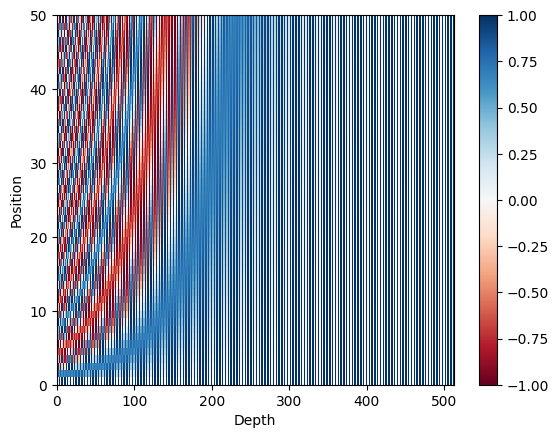

In [ ]:
# Positional encoding


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis,:]

    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 1. Pad Masking
#### Making all the padded tokens, self attention/attention calculation of a word with those paddings will be ignored


* Here output dimn -> (batch_size, 1, 1, seq_len)
          
*  for each 8 attention heads, for each query word it will be multiplied, thats why creating 1, 1 in the middle

##### (batch_size, 8, query_word_len, seq_len) * (batch_size, 1, 1, seq_len)

In [ ]:
# Masking

'''Mask all the pad tokens in the batch of sequence.
It ensures that the model does not treat padding as the input.
The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.
'''
def create_padding_mask(seq):
    """
    seq: padded sentence length (5)
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Adding 2, 3 dimn using tf.newaxis, 2-> As this mask will be multiplied with each attention head and 3-> for each word in a sentance
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
# create_padding_mask(np.array([[1,2,3,0,0,0],[1,2,3,0,0,1]]))

## 2. Looakahead mask

for the first word, its self attention calculation with be ignored with proceeding words i.e. second, third word and so on

In [ ]:
# Looakahead mask

"""The look-ahead mask is used to mask the future tokens in a sequence.
In other words, the mask indicates which entries should not be used.
"""
def create_look_ahead_mask(size):
    """
    The look-ahead mask is used to mask the future tokens in a sequence
    """
    #band_part with this setting creates lower triangular matrix that's why subtracting from 1
    # [[0., 1., 1.],
    #  [0., 0., 1.],
    #  [0., 0., 0.]] output with size:3
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#example
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## 3. SELF-ATTENTION calculation

![image](images/attenion_formula.png)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Args:
    q: query shape == (..., seq_len_q, depth) # NOTE: depth=dk
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk. underroot d_model i.e. underroot(100)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # -1e9 ~ (-INFINITY) => where ever mask is set, make its logit value close to -INF
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## 4. MultiHeadAttention Calculation
#### Its nothing but a RESHAPING !! :)
example :
1. if we have (64, 10, 512)->(BATCH, #words, embeddding) as input, after passiing it though dense layer of size 512 we will get (64, 10, 512)
2. We have three such dense layers representing/for Q, K, V encodings.
3. (64, 10, 512) -> reshape -> (64, 8, 10 ,64) -> (BATCH, attention head, #words, encode)
    '64' is representing encoding of 512 -> 64 dimension
4. (64, 8, 10 ,64)->self-attention-code->(64, 8, 10 ,10) called attention weights, (64, 8, 10 ,64)
5. Concatenate such that 8*64 will be new dimension -> (64, 10, 512)
    
    **Beware embedding dimn must be divisible by no. of heads and always embedding_dimn/heads => encodin_dimn(here 64)**
    
    **NICE HACK** (-_-)

![image](images/multi_head.png)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights


## 5. ENCODER layer

#### -> self Multihead attention -> Residual+Norm -> Feed forward neural network -> Residual+Norm

![image](images/encoder_layer.png)


In [ ]:
def point_wise_feed_forward_network(d_model, dff): #dff = 512
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention

        return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

## 6. DECODER LAYER
#### -> self multihead attention -> residual+norm -> multihead attention(between E & D) -> residual+norm -> feed forward NN -> residual+norm

![image](images/decoder_layer.png)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

## 7. ENCODER
#### Nothing but repetation of Encoder layer :-) + Input embedding vector + positional encoding

![image](images/encoder.png)

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]   #x:(batch, seq_len)
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

## 8. DECODER
#### Nothing but Repetation of decoder layers + posisional encoder + embedding layer

![image](images/decoder.png)

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 9. TRANSFORMER

#### Nothing but encoder+decoder+dense layer
##### (64,10,512) -> dense_layer -> (64,10,vocab_size)

![image](images/transformer.png)


In [ ]:

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

#### So to create a transformer architecture which is now everywhere in NLP models, we require only 9 STEPs :-O

In [ ]:
# tokenizer_a = joblib.load("tokenizer_a")
# tokenizer_q = joblib.load("tokenizer_q")

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

## Custom learning rate, proposed in the paper
#### First learning rate will be high and then after some epochs it will be decreasing ONLY

![image](images/lr.png)


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # Cast step to float32 for compatibility with tf.math.rsqrt
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

### See, increasing and then decreasing

Text(0.5, 0, 'Train Step')

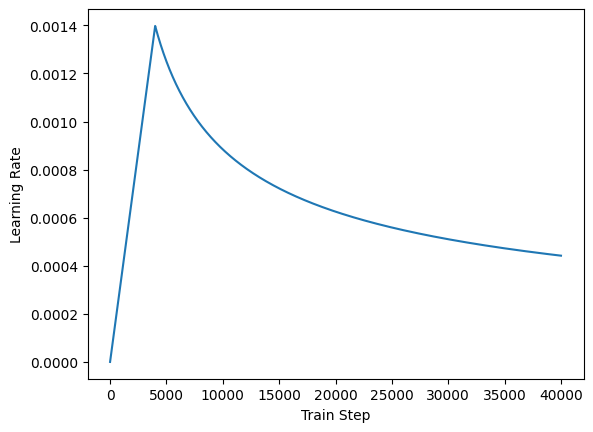

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

##### Custom losss function, same as sparse categorical cross entropy but considers only no padded values

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

### Creating pad mask(encoder), pad mask(decoder), lookahead mask(decoder)

In [ ]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

## Saving model checkpoint

In [ ]:
import transformers

In [ ]:
checkpoint_path = "./checkpoints_test/train"



In [ ]:
import tensorflow as tf

# Assuming you are using a Hugging Face transformer model
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Define the model
model_name = "t5-small"  # Replace with your desired model
transformer = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

checkpoint_path = "./checkpoints_test/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Latest checkpoint restored!!


## Using gradient tape for getting derivatives of loss functions w.r.t. weights then applyiing to optimizer => BACKPROPAGATION

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

## Creating sample transformer to know the no. of trainable parameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

sample_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
sample_transformer.summary()

Model: "transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  1011840   
                                                                 
 decoder_2 (Decoder)         multiple                  1284992   
                                                                 
 dense_200 (Dense)           multiple                  228459    
                                                                 
Total params: 2525291 (9.63 MB)
Trainable params: 2525291 (9.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1


transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
EPOCHS = 20
batch_size = 64
metrics_names = ['loss', 'acc']
train_loss.reset_states()
train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/20
1088/1084 [==============================] - 39s 36ms/step - loss: 6.4938 - acc: 0.0171

epoch 2/20
1088/1084 [==============================] - 3s 3ms/step - loss: 6.0385 - acc: 0.0171

epoch 3/20
1088/1084 [==============================] - 3s 3ms/step - loss: 5.8582 - acc: 0.0173

epoch 4/20
1088/1084 [==============================] - 3s 3ms/step - loss: 5.7388 - acc: 0.0176

epoch 5/20
1088/1084 [==============================] - 2s 2ms/step - loss: 5.6398 - acc: 0.0184
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-36

epoch 6/20
1088/1084 [==============================] - 3s 2ms/step - loss: 5.5424 - acc: 0.0197

epoch 7/20
1088/1084 [==============================] - 2s 2ms/step - loss: 5.4431 - acc: 0.0218

epoch 8/20
1088/1084 [==============================] - 2s 2ms/step - loss: 5.3289 - acc: 0.0244

epoch 9/20
1088/1084 [==============================] - 3s 2ms/step - loss: 5.1984 - acc: 0.0279

epoch 10/20
1088/1084 [==========================

In [ ]:
EPOCHS = 5
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/5
1088/1084 [==============================] - 2s 1ms/step - loss: 3.8218 - acc: 0.0671

epoch 2/5
1088/1084 [==============================] - 2s 2ms/step - loss: 3.7343 - acc: 0.0697

epoch 3/5
1088/1084 [==============================] - 1s 1ms/step - loss: 3.6501 - acc: 0.0722

epoch 4/5
1088/1084 [==============================] - 1s 1ms/step - loss: 3.5691 - acc: 0.0747

epoch 5/5
1088/1084 [==============================] - 1s 1ms/step - loss: 3.4911 - acc: 0.0772
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-40


# With those hyperparameters it seems model is not learning at all, as there is no progress in 25 EPOCHS

In [ ]:
MAX_LENGTH = 200
def evaluate(inp_sentence):
    start_token = [tokenizer_q.vocab_size]
    end_token = [tokenizer_q.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_q.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_a.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
#         print(predictions.shape,"aa",predictions[: ,-1:, :].shape)
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
#         print(predicted_id, output)
    # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_a.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
inp_sentence = "Ṣé àkàrà-òyìnbó aláìlẹ́yin lẹ fẹ́"
a, b = evaluate(inp_sentence)

# RESULTS are ABSURD

In [ ]:
for i in a[1:]:
    print(tokenizer_a.decode([i]))

ó 
dáa
. 
ẹ 
seun
. 
ẹ 
ṣe 
sùúrù 
díẹ
̀ 
pé 
wọ
́
n 
fi 
sílẹ
̀ 
pé 
ti 
sì 
padà 
wá 
sí 
àkànṣeètòàjò 
tí 
a 
sí 
àkànṣeètòàjò 
tó 
bá 
padà 
wá 
ní 
aago 
mẹ
́
ta 
naira 
wà 
ní 
aago 
mẹ
́
ta 
naira 
sí 
ni
.


 ## Lets try with different hyperparameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1
temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
sample_transformer.summary()

Model: "transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  1011840   
                                                                 
 decoder_2 (Decoder)         multiple                  1284992   
                                                                 
 dense_200 (Dense)           multiple                  228459    
                                                                 
Total params: 2525291 (9.63 MB)
Trainable params: 2525291 (9.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_layers = 2
d_model = 256
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

sample_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)
sample_transformer.summary()

Model: "transformer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  1491712   
                                                                 
 decoder_4 (Decoder)         multiple                  2034944   
                                                                 
 dense_298 (Dense)           multiple                  455147    
                                                                 
Total params: 3981803 (15.19 MB)
Trainable params: 3981803 (15.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Now the trainable parameters has increased from 12M to 24M, Lets test this!!

In [ ]:
EPOCHS = 20
batch_size = 64
metrics_names = ['loss', 'acc']
train_loss.reset_states()
train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/20
1088/1084 [==============================] - 2s 1ms/step - loss: 1.5055 - acc: 0.1393

epoch 2/20
1088/1084 [==============================] - 1s 1ms/step - loss: 1.4565 - acc: 0.1404

epoch 3/20
1088/1084 [==============================] - 1s 1ms/step - loss: 1.4091 - acc: 0.1409

epoch 4/20
1088/1084 [==============================] - 1s 1ms/step - loss: 1.3693 - acc: 0.1448

epoch 5/20
1088/1084 [==============================] - 2s 2ms/step - loss: 1.3315 - acc: 0.1457
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-41

epoch 6/20
1088/1084 [==============================] - 1s 1ms/step - loss: 1.2937 - acc: 0.1468

epoch 7/20
1088/1084 [==============================] - 2s 2ms/step - loss: 1.2570 - acc: 0.1493

epoch 8/20
1088/1084 [==============================] - 1s 1ms/step - loss: 1.2213 - acc: 0.1512

epoch 9/20
1088/1084 [==============================] - 1s 1ms/step - loss: 1.1885 - acc: 0.1524

epoch 10/20
1088/1084 [============================

In [ ]:
EPOCHS = 30
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/30
1088/1084 [==============================] - 3s 3ms/step - loss: 0.9214 - acc: 0.1639

epoch 2/30
1088/1084 [==============================] - 1s 1ms/step - loss: 0.9066 - acc: 0.1646

epoch 3/30
1088/1084 [==============================] - 1s 1ms/step - loss: 0.8927 - acc: 0.1654

epoch 4/30
1088/1084 [==============================] - 1s 1ms/step - loss: 0.8797 - acc: 0.1660

epoch 5/30
1088/1084 [==============================] - 1s 1ms/step - loss: 0.8674 - acc: 0.1666
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-45

epoch 6/30
1088/1084 [==============================] - 2s 2ms/step - loss: 0.8554 - acc: 0.1672

epoch 7/30
1088/1084 [==============================] - 1s 1ms/step - loss: 0.8443 - acc: 0.1684

epoch 8/30
1088/1084 [==============================] - 1s 1ms/step - loss: 0.8354 - acc: 0.1690

epoch 9/30
1088/1084 [==============================] - 1s 1ms/step - loss: 0.8258 - acc: 0.1694

epoch 10/30
1088/1084 [============================

## Learning is slow, but not stagnant (-__-)

In [ ]:
EPOCHS = 100
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(50, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 51/100
1088/1084 [==============================] - 1s 1ms/step - loss: 0.6797 - acc: 0.1756

epoch 52/100
1088/1084 [==============================] - 1s 1ms/step - loss: 0.6752 - acc: 0.1758

epoch 53/100
1088/1084 [==============================] - 1s 1ms/step - loss: 0.6710 - acc: 0.1762

epoch 54/100
1088/1084 [==============================] - 1s 1ms/step - loss: 0.6669 - acc: 0.1764

epoch 55/100
1088/1084 [==============================] - 1s 1ms/step - loss: 0.6630 - acc: 0.1767
Saving checkpoint for epoch 55 at ./checkpoints_test/train/ckpt-51

epoch 56/100
1088/1084 [==============================] - 1s 1ms/step - loss: 0.6590 - acc: 0.1769

epoch 57/100
1088/1084 [==============================] - 1s 1ms/step - loss: 0.6550 - acc: 0.1772

epoch 58/100
1088/1084 [==============================] - 1s 1ms/step - loss: 0.6512 - acc: 0.1773

epoch 59/100
1088/1084 [==============================] - 1s 1ms/step - loss: 0.6473 - acc: 0.1773

epoch 60/100
1088/1084 [========

In [ ]:
EPOCHS = 150
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(100, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 101/150
1088/1084 [==============================] - 1s 1ms/step - loss: 0.5409 - acc: 0.1826

epoch 102/150
1088/1084 [==============================] - 1s 1ms/step - loss: 0.5392 - acc: 0.1827

epoch 103/150
1088/1084 [==============================] - 1s 1ms/step - loss: 0.5375 - acc: 0.1828

epoch 104/150
1088/1084 [==============================] - 1s 1ms/step - loss: 0.5360 - acc: 0.1828

epoch 105/150
1088/1084 [==============================] - 1s 1ms/step - loss: 0.5344 - acc: 0.1828
Saving checkpoint for epoch 105 at ./checkpoints_test/train/ckpt-61

epoch 106/150
1088/1084 [==============================] - 1s 1ms/step - loss: 0.5329 - acc: 0.1829

epoch 107/150
1088/1084 [==============================] - 1s 1ms/step - loss: 0.5314 - acc: 0.1829

epoch 108/150
1088/1084 [==============================] - 1s 1ms/step - loss: 0.5299 - acc: 0.1830

epoch 109/150
1088/1084 [==============================] - 1s 1ms/step - loss: 0.5284 - acc: 0.1830

epoch 110/150
1088/108

In [ ]:
EPOCHS = 200
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(150, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 151/200
1088/1084 [==============================] - 2s 1ms/step - loss: 0.4790 - acc: 0.1856

epoch 152/200
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4781 - acc: 0.1856

epoch 153/200
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4771 - acc: 0.1856

epoch 154/200
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4762 - acc: 0.1856

epoch 155/200
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4754 - acc: 0.1857
Saving checkpoint for epoch 155 at ./checkpoints_test/train/ckpt-71

epoch 156/200
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4745 - acc: 0.1857

epoch 157/200
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4736 - acc: 0.1857

epoch 158/200
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4728 - acc: 0.1858

epoch 159/200
1088/1084 [==============================] - 2s 2ms/step - loss: 0.4719 - acc: 0.1859

epoch 160/200
1088/108

In [ ]:
EPOCHS = 300
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(200, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 201/300
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4416 - acc: 0.1871

epoch 202/300
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4410 - acc: 0.1872

epoch 203/300
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4405 - acc: 0.1872

epoch 204/300
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4399 - acc: 0.1872

epoch 205/300
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4393 - acc: 0.1873
Saving checkpoint for epoch 205 at ./checkpoints_test/train/ckpt-81

epoch 206/300
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4387 - acc: 0.1873

epoch 207/300
1088/1084 [==============================] - 2s 1ms/step - loss: 0.4382 - acc: 0.1874

epoch 208/300
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4377 - acc: 0.1874

epoch 209/300
1088/1084 [==============================] - 1s 1ms/step - loss: 0.4371 - acc: 0.1874

epoch 210/300
1088/108

In [ ]:
EPOCHS = 350
batch_size = 64
metrics_names = ['loss', 'acc']
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(300, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)

    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]

        pb_i.add(batch_size, values=values)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 301/350
1088/1084 [==============================] - 1s 1ms/step - loss: 0.3960 - acc: 0.1892

epoch 302/350
1088/1084 [==============================] - 1s 1ms/step - loss: 0.3956 - acc: 0.1892

epoch 303/350
1088/1084 [==============================] - 1s 1ms/step - loss: 0.3953 - acc: 0.1892

epoch 304/350
1088/1084 [==============================] - 1s 1ms/step - loss: 0.3949 - acc: 0.1893

epoch 305/350
1088/1084 [==============================] - 1s 1ms/step - loss: 0.3946 - acc: 0.1893
Saving checkpoint for epoch 305 at ./checkpoints_test/train/ckpt-101

epoch 306/350
1088/1084 [==============================] - 1s 1ms/step - loss: 0.3943 - acc: 0.1893

epoch 307/350
1088/1084 [==============================] - 1s 1ms/step - loss: 0.3939 - acc: 0.1893

epoch 308/350
1088/1084 [==============================] - 1s 1ms/step - loss: 0.3936 - acc: 0.1893

epoch 309/350
1088/1084 [==============================] - 1s 1ms/step - loss: 0.3933 - acc: 0.1894

epoch 310/350
1088/10

# EPOCH:350, I think its enough, let's check what type of REPLIES that CHATBOT is generating

In [ ]:
# joblib.dump(tokenizer_q, "tokenizer_q")
# joblib.dump(tokenizer_a, "tokenizer_a")
# transformer.save_weights('transformer_model/weights')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    sentence = sentence.split(" ")
    predicted_sentence = predicted_sentence.split(" ")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)



def plot_attention_weights(attention,tokenizer_q, tokenizer_a, sentence, result, layer):

    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_q.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)
    #(1, 8, 5, 4) --> (8, 5, 4)
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights [:-1, :]
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)-1))

        ax.set_ylim(len(result)-1.5, -0.5)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        x = ['<start>']+[tokenizer_q.decode([i]) for i in sentence]+['<end>']
        y = [tokenizer_a.decode([i]) for i in result if i < tokenizer_a.vocab_size]
        ax.set_xticklabels([''] + x, fontdict=fontdict, rotation=90)
        ax.set_yticklabels([''] + y, fontdict=fontdict)


        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()


MAX_LENGTH = 27

def evaluate(inp_sentence, model,  tokenizer_q, tokenizer_a):
    start_token = [tokenizer_q.vocab_size]
    end_token = [tokenizer_q.vocab_size + 1]

    # All questions has the start and end token
    inp_sentence = start_token + tokenizer_q.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 'answers' start token : 27358
    decoder_input = [tokenizer_a.vocab_size]
    decoder_input = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = model(encoder_input,
                                                     decoder_input,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_a.vocab_size+1:
            print(f"=============\nGot end token\n=============")
            return tf.squeeze(decoder_input, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    return tf.squeeze(decoder_input, axis=0), attention_weights

In [ ]:
def reply(sentence, transformer,  tokenizer_q, tokenizer_a, plot=''):
    result, attention_weights = evaluate(sentence, transformer,  tokenizer_q, tokenizer_a)
#     print("Attention_Blocks:", list(attention_weights.keys()))
    predicted_sentence = tokenizer_a.decode([i for i in result
                                            if i < tokenizer_a.vocab_size])

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    if plot:
        plot_attention_weights(attention_weights,tokenizer_q, tokenizer_a, sentence, result, plot)
    return sentence, predicted_sentence

Got end token
Input: iṢé àkàrà-òyìnbó aláìlẹ́yin lẹ fẹ́
Predicted translation: nan


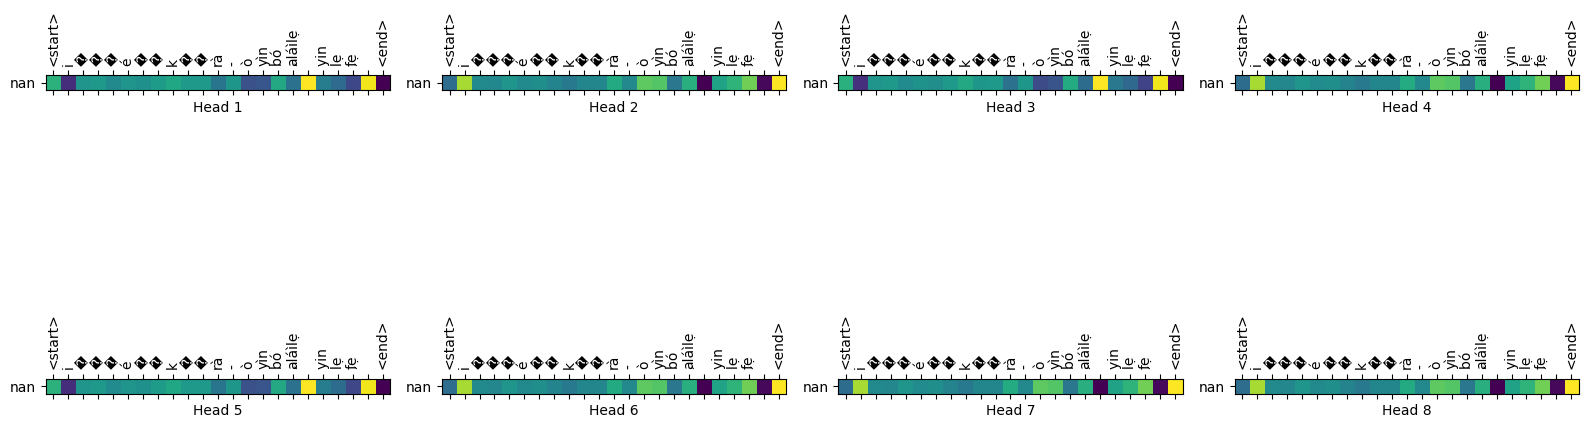

('iṢé àkàrà-òyìnbó aláìlẹ́yin lẹ fẹ́', 'nan')

In [ ]:
inp_sentence = "iṢé àkàrà-òyìnbó aláìlẹ́yin lẹ fẹ́"
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a, "decoder_layer2_block2")

## OUTPUTS are not absurd at all, It has LEARNED

In [ ]:
inp_sentence = "Ẹ káàbọ̀, sà. Kí ni mo lè ṣe fún yín?"
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a)

Got end token
Input: Ẹ káàbọ̀, sà. Kí ni mo lè ṣe fún yín?
Predicted translation:  bẹẹni a ni irinṣẹ abẹ nla.


('Ẹ káàbọ̀, sà. Kí ni mo lè ṣe fún yín?', ' bẹẹni a ni irinṣẹ abẹ nla.')

In [ ]:
train.iloc[400:406]

In [ ]:
validation.iloc[400:406]

In [ ]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
test_q = train["Question"].values[:10]
test_a = train["Answer"].values[:10]
bss = []
for i in range(10):
    input_test_sentence = test_q[i]
    input_sentence, pred_string = reply(input_test_sentence, transformer,  tokenizer_q, tokenizer_a, plot='')
    print("Actual:", test_a[i])
    reference = [test_a[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    bs.append(bs)


Input: ó dára. fún mi ní ìdì ọ̀gẹ̀dẹ̀ wẹẹrẹ kan àti ìgò ẹ̀pà kan. eélòó ni gbogbo rẹ̀ lápapọ̀
Predicted translation: gbogbo èyí tó gùn yẹn ni igba náírà àwọn èyí tí a dì yẹn jẹ́ ọgọ́rùnún 
Actual: gbogbo rẹ̀ jẹ́ ọgọ́rùnún mẹ́jọ náírà lápapọ̀


AttributeError: 'float' object has no attribute 'append'

In [ ]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
test_q = train["Question"].values[:10]
test_a = train["Answer"].values[:10]
bss = []
for i in range(10):
    input_test_sentence = test_q[i]
    input_sentence, pred_string = reply(input_test_sentence, transformer,  tokenizer_q, tokenizer_a, plot='')
    print("Actual:", test_a[i])
    reference = [test_a[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    bss.append(bs) # Append the float value 'bs' to the list 'bss'

Input: ó dára. fún mi ní ìdì ọ̀gẹ̀dẹ̀ wẹẹrẹ kan àti ìgò ẹ̀pà kan. eélòó ni gbogbo rẹ̀ lápapọ̀
Predicted translation: gbogbo èyí tó gùn yẹn ni igba náírà àwọn èyí tí a dì yẹn jẹ́ ọgọ́rùnún 
Actual: gbogbo rẹ̀ jẹ́ ọgọ́rùnún mẹ́jọ náírà lápapọ̀
Got end token
Input: báwo ni i̇lorin şe ri
Predicted translation: zagbayi lọ́nà iléìwòsàn.
Actual: llú nlá ni ilú lọrin. oun si ni olúilú ìpínlè kwárà.
Got end token
Input: ẹgbẹ̀run méjì àbọ̀ naira
Predicted translation: ẹ ǹlẹ́ o.
Actual: bẹ́ẹ̀ni.
Got end token
Input:  mo fẹ ra kọmputa aleebu.
Predicted translation:  a ni kọmputa aleebu to dara pupọ.
Actual:  a ni kọmputa aleebu to dara pupọ.
Got end token
Input:  ṣé ẹ ni foonu alagbeka
Predicted translation:  bẹẹni a ni ẹran malu tuntun.
Actual:  bẹẹni a ni foonu alagbeka tuntun.
Got end token
Input:  o dara mo gba.
Predicted translation:  o ṣeun sir.
Actual:  o ṣeun sir.
Got end token
Input: màá san ogójì naira.
Predicted translation: ọgọ́rùnún méjì náírà n200.
Actual: àádọ̀rin naira
Got e

In [ ]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
test_q = validation["Question"].values[100:110]
test_a = validation["Answer"].values[100:110]
bss = []
for i in range(10):
    input_test_sentence = test_q[i]
    input_sentence, pred_string = reply(input_test_sentence, transformer,  tokenizer_q, tokenizer_a, plot='')
    print("Actual:", test_a[i])
    reference = [test_a[i].split()] # the original
    translation = pred_string.split() # trasilated using model

Got end token
Input: ah ọgọ́rùnún méjì n200.
Predicted translation: ẹ kú àbọ̀ .
Actual: kò gbà mo kàn lè tà á ní n230 á jẹ́ pé mo ti dín yín ní n20 ní tipátipá.
Got end token
Input: eélòó ni ẹ máa tà á jálẹ̀jálẹ̀
Predicted translation: ó dàbò.
Actual: eélòó ni ẹ máa rà á jálẹ̀jálẹ̀
Got end token
Input: ọjọ́ kìíní sí ìkẹwàá ní oṣù kẹjọ /ọ́gọ́sìtì
Predicted translation: mo nílò ohunmímu ààbọ̀ agolo mílíìkì ‘nescafe’ ẹyin méjì àti búrẹ́dì ọgbọ̀n náírà. eélòó ni gbogbo ẹ̀
Actual: ọjọ́ mẹ́wàá kọ́ yẹn
Got end token
Input: ọ̀rò ìfọkàntán kọ́ yìí. ohun tó ṣẹlẹ̀ ni pé nígbà míràn oníbàárà á pa ètò rẹ̀ dà àwa ló sì máa fara da òfò rẹ̀.
Predicted translation: iye kan náà ni wọ́n bá dé láti ọjà.
Actual: ó dáa. ó ti yé mi. ẹgbẹ̀rún mẹ́ta náírà 3000 rèé.
Got end token
Input: eélòó ni àwọn tó wà nínú abọ́ yìí
Predicted translation: ẹ ǹlẹ́ o.
Actual: eléyìí jẹ́ ọgọ́rùnún mẹ́ta náírà èyí ọgọ́rùnún márùnún náírà.
Got end token
Input:  mo fẹ ra bata tuntun.
Predicted translation:  a ni tabili tuntun ti

In [ ]:
# num_layers = 2
# d_model = 256
# dff = 512
# num_heads = 8
# input_vocab_size = tokenizer_q.vocab_size + 2
# target_vocab_size = tokenizer_a.vocab_size + 2
# dropout_rate = 0.1

# load_transformer = Transformer(num_layers, d_model, num_heads, dff,
#                           input_vocab_size, target_vocab_size,
#                           pe_input=input_vocab_size,
#                           pe_target=target_vocab_size,
#                           rate=dropout_rate)
# load_transformer.load_weights('transformer_model/weights')

Got end token
Input: Ó dáa. Onírú èròja lẹ fẹ́ẹ́ rà?
Predicted translation: zagbayi lọ́nà iléìwòsàn.


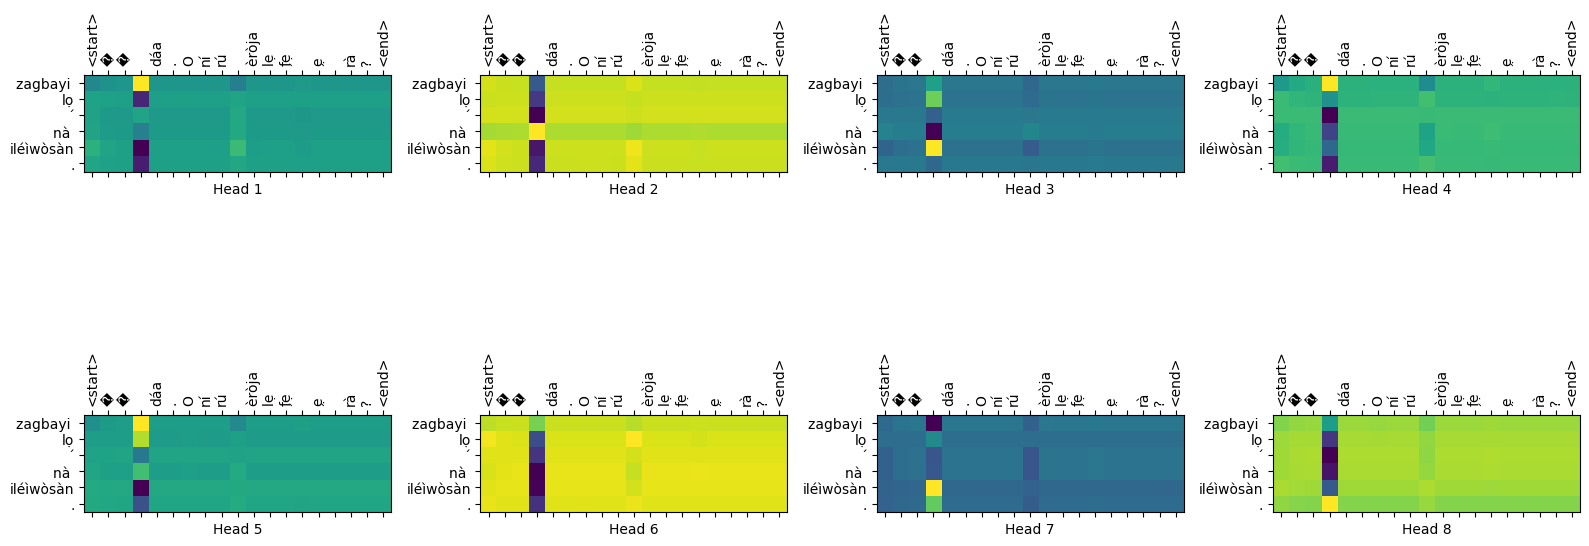

('Ó dáa. Onírú èròja lẹ fẹ́ẹ́ rà?', 'zagbayi lọ́nà iléìwòsàn.')

In [ ]:
inp_sentence = "Ó dáa. Onírú èròja lẹ fẹ́ẹ́ rà?"
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a, "decoder_layer2_block2")

* Results are great, better than encoder-decoder with bahadenau attention mechanism
* Still we can see the results are not perfect, because the architecture has less parameters plus the dataset is not very big and transformers works close to humans with large data and large trainable parameters

# On random inputs!
### Results are genuine

In [ ]:
inp_sentence = "o daa"
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a)


Got end token
Input: o daa
Predicted translation: ó dáa.


('o daa', 'ó dáa.')

In [ ]:
inp_sentence = "Ìyẹn kò ṣòro. Ẹ máa san ìdajì owó ní àsansílẹ̀."
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a)


Got end token
Input: Ìyẹn kò ṣòro. Ẹ máa san ìdajì owó ní àsansílẹ̀.
Predicted translation: óyá jẹ́ ká lọ


('Ìyẹn kò ṣòro. Ẹ máa san ìdajì owó ní àsansílẹ̀.', 'óyá jẹ́ ká lọ')

#### Making sense haha : ) "who are you"

# Even with this small architecture its working fine, what else it could do If I train it with trainable parameters with more data